# Neural Networks (Part 3): Optimizers

In part 3 of this neural networks series of tutorials we'll discuss topics around batching and optimizers:
- Datasets and Dataloaders
- Batching and Batch Sizes
- Optimizers: SGD, Adam, AdamW, RAdam
- Training MNIST using Adam

We'll again load the usual libraries we'll need, set a seed, and set a device for those who'd prefer to work on the GPU. We'll also continue to use our MLP creator function, our parameter counter, and our learning rate finder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def multilayer_mlp(num_features, num_targets, hidden_sizes, p=0, normalization=None, activation=nn.ReLU()):
    """
    Get an arbitrary MLP model with L=len(hidden_sizes)+1 layers
    Optionally, can include a batchnorm and dropout in each layer, and change the activation function
    """
    def get_leaf_layers(m):
        """Used to flatten the layers out so the model doesn't recursively nest"""
        children = list(m.children())
        if not children:
            return [m]
        leaves = []
        for l in children:
            leaves.extend(get_leaf_layers(l))
        return leaves
    hidden_sizes = [num_features] + hidden_sizes
    n_layers = len(hidden_sizes)
    model = nn.Sequential()
    for l in range(n_layers-1):
        linear = nn.Linear(hidden_sizes[l], hidden_sizes[l+1])
        dropout = None if p == 0. else nn.Dropout(p)
        layer_norm = None if normalization is None else normalization(hidden_sizes[l+1])
        blocks = [linear, layer_norm, activation, dropout]
        layer_block = nn.Sequential(*[layer for layer in blocks if layer is not None])
        model = nn.Sequential(*([model] + [layer_block]))
    output = nn.Sequential(nn.Linear(hidden_sizes[-1], num_targets))
    model = nn.Sequential(*([model] + [output]))
    model = nn.Sequential(*get_leaf_layers(model))
    return model

def lr_find(dataset, model, opt, loss_fn, batch_size=128, **kwargs):
    from torch_lr_finder import LRFinder
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    lr_finder = LRFinder(model, opt, loss_fn, device=device)
    lr_finder.range_test(dataloader, **kwargs)
    lr_finder.plot()
    lr_finder.reset()
    
def num_params(model):
    return sum([p.numel() for p in model.parameters()])

## Data Prep: MNIST

For this tutorial we'll want to start going bigger with the data we're using. We'll start by taking baby steps, just using the MNIST dataset. Recall the MNIST dataset consists of 70k grayscale images of handwritten digits, each image of size 28x28 and being labeled with a digit 0-9 (so 10 multiclass classification with 10 classes). The openml link we're downloading the data from has the images in *flattened* form, meaning each 28x28 image gets flattened to a single vector of length 28*28=784. We can always turn the back into images by reshaping. Below is a plot of a random sample of MNIST images.

In [5]:
def get_mnist_data():
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.datasets import fetch_openml
    data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = data[0].astype(float)
    X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
    y = data[1].astype(int)
    return torch.tensor(X).float(), torch.tensor(y).long()

X,y = get_mnist_data()
X.shape, y.shape

(torch.Size([70000, 784]), torch.Size([70000]))

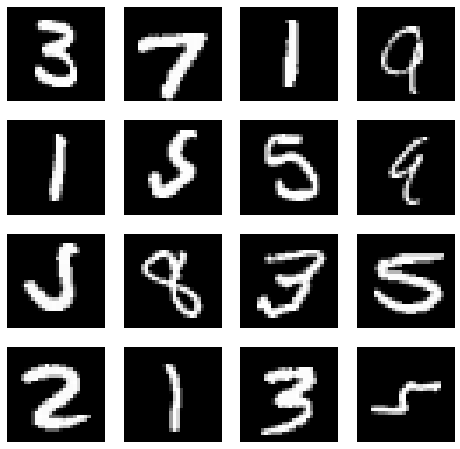

In [6]:
def plot_images(X, n=4):
    from matplotlib import cm
    idx = np.random.choice(len(X), n**2, replace=False)
    _, ax = plt.subplots(nrows=n, ncols=n, figsize=(8, 8))
    cnt = 0
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(X[idx[cnt]].reshape(28, 28), aspect='auto', cmap=cm.gray)
            ax[i, j].axis('off')
            cnt += 1
    plt.show()
    
plot_images(X.cpu().numpy(), n=4)

We might as well go ahead and split the dataset up into training and test sets. Following the convention with this dataset, we'll take 60k images for training and 10k images for testing.

While we're at it, let's go ahead and see how well a baseline, no frills classical model does classifying the images in this dataset. We'll use the random forest with the defaults (100 trees). Looks like it can already classify MNIST images with 96.8% accuracy! That's a pretty high bar to beat.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([60000]),
 torch.Size([10000]))

In [8]:
model = RandomForestClassifier(random_state=seed)
model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
model.score(X_test.cpu().numpy(), y_test.cpu().numpy())

0.9679

## Datasets, Dataloaders, and Batches

So far we've been working with data the same way one might do in sklearn, having an input data array `X` and an output data array `y` that we keep track of separately. Pytorch natively prefers, however, that data examples `x,y` be grouped together in pairs, so that the dataset is a list of these input-output example pairs:
```
dataset = [(X[0], y[0]), (X[1], y[1]), ..., (X[N-1], y[N-1])]
```
Pytorch likes it this way because it makes it easier to convert datasets to dataloaders and work in batches, something we'll get to shortly. 

We can pretty easily create pytorch compatible datasets by creating a list of tuples for both our training and test sets. We'll call the training dataset `train_set` and the test dataset `test_set`.

In [9]:
train_set = [(X_train[i], y_train[i]) for i in range(len(y_train))]
test_set = [(X_test[i], y_test[i]) for i in range(len(y_test))]

With our data in this form we can talk about dataloaders, probably the most important data structure in pytorch. Basically put, a dataloader splits data up into **batches** according to a specified **batch size**. We'll deal with why we might want to do this in a second. First, the how.

To convert a dataset into a dataloader, we use the `torch.utils.data.DataLoader` class, passing in the dataset, a batch size, and other optional arguments we'll cover as we go. Here, we'll convert our `train_set` and `test_set` objects into dataloaders `train_loader` and `test_loader`. For now we'll use a batch size of 32. We'll also pass in `shuffle=True`, which tells pytorch to shuffle the datasets randomly, a good idea for training models later on.

In [10]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

What exactly is a dataloader though? Basically, a dataloader takes your dataset and splits it into chunks each with `batch_size` many data examples. Each iteration of the dataloader then gives `X, y` pairs of shuffled examples, but `batch_size` many of them at a time. It does this until it gets through the whole dataset, at which point it starts over again. Note that by using the datasets approach above you're guaranteed each `x,y` pair will be the appropriate feature-target pair, i.e. the data samples will always shuffle together in input-output pairs.

One subtlety to get used to is that pytorch dataloaders are python *generator* objects. Roughly speaking, a generator is a list that hasn't been instantiated. All you can do is grab the next item, iteratively, using `next(iter(dataloader))`. You can also loop over if using `for X, y in dataloader` and it'll work the usual way. Just remember that, as a generator, the `dataloader` object can't be indexed into without converting it into a list first.
 
Here's an example of grabbing the next *batch* from a dataloader. Notice that the 0-dimension is size 32, which is our batch size. For inputs `X`, the 1-dimension is the feature number, in our case 784. For targets `y`, the 1-dimension (if any) will be the number of classes or targets.

In [11]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([32, 784]), torch.Size([32]))

In [12]:
i = 0
for X, y in train_loader:
    print(X.shape, y.shape)
    i += 1
    if i == 5:
        break

torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])


If you want the whole dataloader in memory at once you first have to convert it into a list using `list(dataloader)`. You usually will not want to do this though, as we'll see. It can be useful for telling us how many batches are in the dataset though. In our case, it looks like there are 1875 batches in the training set when using a batch size of 32. That makes sense, given that `32*1875=60,000` is our training set size. It won't always be exact like this. Sometimes you'll have leftover data in the last batch when the batch number and the dataset size don't divide evenly. This is true, for example, with the test set. There, `32*313=10,016`. But the test set size is 10,000. Evidently the last batch only contains `10,000-32*(313-1)=16` examples.

In [13]:
print(f'# batches in training set: {len(list(train_loader))}')
print(f'# batches in test set: {len(list(test_loader))}')

# batches in training set: 1875
# batches in test set: 313


Why would we want to bother with all this batching stuff though when we can just work with the whole dataset at once? The simple reason is, for any reasonably large dataset, doing deep learning slows to a crawl if you try to feed in all the data at once. You'll find that it takes *forever* to do a forward pass of the network. Worse, you might (and often will) run out of memory either on the CPU or the GPU. 

For example, the MNIST dataset is considered "small" by today's deep learning standards. But if you try to pass all 70k images through any decent deep learning model at one time you'll probably slow your performance way down. Assuming 4 bytes per number, a 28x28 image will take up `4*28*28=3186` bytes, or 3.186 kB of memory. That means 70,000 images will take up 219,520,000 bytes, or 219 MB. That doesn't seem like a lot, but it's enough to slow down your performance a lot, especially when you're passing that much data through a model of millions of parameters for many iterations.

A clever way around this problem is to not pass through *all* the data in one forward pass of the network, but to only pass through smaller batches of it at a time. This is what dataloaders allow you to do. They're an efficient way to feed data to your model in a way that keeps up system performance and avoids crashing your CPU/GPU.

This isn't the only reason batching is a good idea though. It turns out that batching your data also acts as a form of regularization! Essentially, when you feed data through a neural network in batches, it will only update the gradients based on the data in *that particular batch*. But the data in any given batch is just a random subsample of the total dataset, meaning it's only a *guess* of what the best, true gradients should be. The smaller the batch size, the more random this estimate will be. A batch size of 1 will mean *a lot* of regularization and randomness during training, and a batch size of `N`, the dataset size, will mean no regularization or randomness at all.

The introduction of the batch size thus means we've got a new hyperparameter to tune when training models. How should it be tuned? The emerging rule of thumb from experiments is that you want to pick the *largest* batch size that will still allow your data to fit in memory without slowing down system performance. If you're training on the GPU, that means you want to pick the largest batch size that will let your data and model fit on the GPU without getting a Cuda out of memory error. There's no reason you *have* to do it this way. Just that experiments have shown that models tend to train the best when you use as large a batch size as possible, without crashing your system or GPU.

**Note:** It's also worth mentioning that there is a rough, rule of thumb tradeoff between learning rate and batch size. Essentially, if you multiply the batch size by a factor `k`, you'll want to make sure to also multiply the learning rate by that same factor `k` to ensure good training. For example, if you double the batch size, you should also double the learning rate, otherwise you'll be training with a smaller learning rate than you have to. If you halve the batch size, you should halve the learning rate, otherwise your model may fail to converge. This is just a rule of thumb though. Other rules of thumb have been proposed as well, but this linear rule is the easiest to remember. But at the end of the day, don't forget you always have the learning rate finder to help you out.

In deep learning, when working with batches, a complete cycle through all of the data is called an **epoch**. When the training dataloader has exhausted all the batches and starts over, the model is said to have completed one epoch of training. Note the subtle difference between an *epoch* and an *iteration*. An iteration is how many times the model goes through the loop, not how many times it goes through the dataset. Before now this distinction didn't matter, since each iteration was also an epoch, as we were passing through all the data at once.

Since we've covered dataloaders, we've covered the last *major* piece we need to add to our `train_model` function. Instead of taking in data in `X_train, y_train, X_test, y_test` format, we'll want to modify the function to take in dataloaders in `train_loader`, `test_loader` format. This also means we'll need to modify the training loop to iterate over these dataloaders separately in batches, first training and then inference. That means a double loop. Can't be avoided unfortunately. We'll have the function returned both the trained model, as well as the training losses for each batch so we can plot them if we wish.

In [14]:
def train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=None, scheduler=None):
    losses = []
    for epoch in tqdm(range(num_epochs)):
        # training
        model = model.train()
        train_loss = 0
        for X, y in tqdm(train_loader, leave=False):
            X = X.to(device)
            y = y.to(device)
            opt.zero_grad()
            yhat = model(X)
            loss = loss_fn(yhat, y)
            loss.backward()
            opt.step()
            if scheduler is not None:
                scheduler.step()
            losses.append(float(loss))
            train_loss += loss
        avg_train_loss = train_loss / len(train_loader)
        # inference
        if test_loader is not None:
            model = model.eval()
            test_loss = 0
            for X, y in tqdm(test_loader, leave=False):
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                loss = loss_fn(yhat, y)
                test_loss += loss
            avg_test_loss = test_loss / len(test_loader)
        else:
            avg_test_loss = None
        if num_epochs <= 10 or epoch % (num_epochs // 10) == 0:
            print(f'epoch: {epoch} \t\t train loss: {avg_train_loss} \t\t test loss: {avg_test_loss}')
    if not num_epochs <= 10 and not epoch % (num_epochs // 10) == 0:
        print(f'epoch: {epoch} \t\t train loss: {avg_train_loss} \t\t test loss: {avg_test_loss}')
    return model, losses

Just to see how things look, let's create and train a light softmax regression model (i.e. linear regression with a softmax activation) on MNIST really quick. Recall that when doing multiclass classification with the cross entropy loss, we leave off the softmax from the model and just feed in the logits directly. This effectively means that our model is using just a single linear layer.

We'll use a batch size of 128 (I could possibly go larger than that, but I didn't try). Let's train for 10 epochs and then check the test set accuracy.

In [15]:
num_features = 28 * 28
num_targets = 10

model = nn.Linear(num_features, num_targets)
model

Linear(in_features=784, out_features=10, bias=True)

In [16]:
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-01


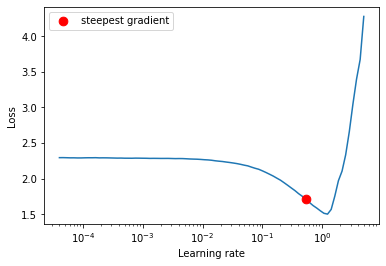

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=1)
loss_fn = nn.CrossEntropyLoss()
lr_find(train_set, model, opt, loss_fn, batch_size=batch_size, start_lr=1e-5, end_lr=10)

In [18]:
num_epochs = 10
opt = torch.optim.SGD(model.parameters(), lr=0.5)
loss_fn = nn.CrossEntropyLoss()
model, losses = train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=test_loader, scheduler=None)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 0 		 train loss: 0.39942747354507446 		 test loss: 0.3333606421947479


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 1 		 train loss: 0.3075084686279297 		 test loss: 0.312530517578125


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 2 		 train loss: 0.2921909689903259 		 test loss: 0.29317575693130493


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 3 		 train loss: 0.28409621119499207 		 test loss: 0.28768157958984375


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 4 		 train loss: 0.2787856459617615 		 test loss: 0.30179792642593384


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 5 		 train loss: 0.27507102489471436 		 test loss: 0.28964418172836304


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 6 		 train loss: 0.27121222019195557 		 test loss: 0.29737579822540283


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 7 		 train loss: 0.26887306571006775 		 test loss: 0.2883709669113159


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 8 		 train loss: 0.26661020517349243 		 test loss: 0.289079487323761


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 9 		 train loss: 0.2644115388393402 		 test loss: 0.28108370304107666


Notice how quickly the model trained. It would be *much* slower if we tried to train it without using batches. Try it if you want. Take batch sizes of `len(train_set)` and `len(train_set)` and see how much slower training is.

The loss barely changed over 10 epochs, but it does look pretty low on both ends. There's a hint the model is *underfitting* since the test loss appears so much lower than the training loss across much of training. That's not surprising, given we're just using softmax regression, which is logistic regression for multiple classes.

Let's go ahead and write a function `get_scores` that can score our model using dataloaders with any sklearn score function `score_fn` we might pass in. Notice the loops look almost exactly the same as the training loop in the `train_model` function above. The main difference is that we're not calling `loss.backward()`, nor are we stepping the optimizer or the scheduler. This is what a standard inference loop looks like. Notice how we also set the model to eval mode at the top of the function.

We'll use the function here to get the model accuracy on our training and test sets. It looks like we're already at about 92% test accuracy with this simple softmax regression model. Adding hidden layers will probably help up it even more, hopefully to get above the random forest accuracy of 96.8% from above.

In [19]:
def get_scores(train_loader, model, score_fn, test_loader=None):
    # score_fn must be any valid sklearn scoring function that acts directly on labels
    # currently only works for multiclass classification models, need to modify for binary or regression
    model = model.eval()
    train_scores = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        yhat = model(X).detach()
        y_pred = yhat.argmax(dim=-1).long()
        score = score_fn(y.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())
        train_scores.append(score)
    print(f'avg train {score_fn.__name__}: {sum(train_scores) / len(train_scores)}')
    if test_loader is not None:
        test_scores = []
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            yhat = model(X).detach()
            y_pred = yhat.argmax(dim=-1).long()
            score = score_fn(y.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())
            test_scores.append(score)
        print(f'avg test {score_fn.__name__}: {sum(test_scores) / len(test_scores)}')

get_scores(train_loader, model, accuracy_score, test_loader=test_loader)

avg train accuracy_score: 0.9288268479033405
avg test accuracy_score: 0.9215783227848101


Last, let's go ahead and plot the losses as a function of each iteration of training. Notice a couple of things:
- The loss is on average decreasing as a function of time, which is what we want to happen when training model
- The loss curve is very bumpy. This is due to SGD running on batches, which causes randomness in the loss estimates and the gradient updates. We'll discuss this more below.

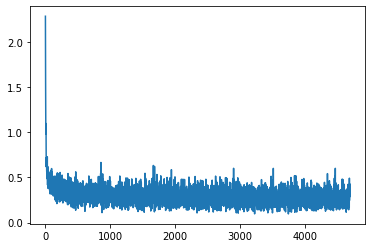

In [20]:
plt.plot(losses)

## Optimizers

Changing from processing the entire dataset at once to just processing it in batches introduces new subtlety to training models that we didn't have before. When processing the full dataset, gradient descent works exactly one way. At each iteration the gradients were exact, meaning the model truly was moving in the "best direction" with each optimizer step, relative to the training dataset. But now we're moving to just training the model on batches. That means that each each iteration the gradients are calculated from that individual batch alone (a random sample of the training set), and hence they're no longer the exact "true" gradients from the full training set. 

### Stochastic Gradient Descent (SGD)

Since the gradients are used to decide which direction to step the update, and by how much to step, that means that we're now taking more noisy, random steps towards the minimum rather than marching straight in. So now our naive use of gradient descent, i.e. `SGD`, means something a bit different than it did before.

This new version of gradient descent is called **stochastic gradient descent** or **SGD**, hence the reason for the pytorch name `SGD`. The inclusion of "stochastic" in the name refers to the fact that we're now using noisy gradients, which will tend to make our march to the minimum more noisy than before. That means a lower learning rate will be needed to not step "too far" off the mark, hence the longer the model will have to train to converge. It's kind of like the difference between walking home sober, and walking home a little drunk. When you're drunk (more noise), you'll tend to stagger around more and take longer tot get home than when you're sober (less noise).

This extra randomness in gradient descent seems mostly undesired, since it means lower learning rates and longer training times. One way to control it is by tuning the batch size. The higher the batch size, the less randomness the optimizer will have, since it'll have a better estimate of its gradients and hence take better steps towards the minimum. A batch size of 1 is the *most random* version of SGD you can have, while a batch size of N is the *least random*.

You've already seen it, but here again is an example of how to implement standard, vanilla SGD.

In [21]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

### SGD with Momentum

Another way to tweak SGD to be less random is to use a concept called **momentum**. The idea is this: Our gradient estimates are noisy, so maybe we should smooth them out to make them less noisy. Instead of using the gradients directly to update the parameters, we'll use the smoothed gradients to update them. The smoothed gradients are calculated in a time series sense using *exponential smoothing*. This technique looks at all gradients calculated during training and takes an exponentially weighted average of them, so that the most recent gradients get higher weights than the least recent ones. The effect of this is kind of like a sliding window: to smooth the gradients out and make them less noisy.

In mathy language, SGD with momentum works as follows. Given a model with parameters $\boldsymbol{\theta}$, a learning rate $\alpha$, and a **momentum** hyperparameter $\mu$, each time step $t$ of the optimizer looks like
$$
\begin{aligned}
    \boldsymbol{m}_t & = \mu \boldsymbol{m}_{t-1} + \frac{dL(\boldsymbol{\theta}_t)}{d\boldsymbol{\theta}}, \\
    \boldsymbol{\theta}_t & = \boldsymbol{\theta}_{t-1} - \alpha \boldsymbol{m}_t.
\end{aligned}
$$
The first line is the exponential smoothing, where we calculate the smoothed gradient $m_t$ that will then be fed into the gradient descent update in the second line. The momentum term $\mu$ controls how much smoothing we want. Setting $\mu=0$ means no smoothing, just regular SGD. Setting $\mu$ infinitely high means infinite smoothing, i.e. the gradients $m_t$ won't update at all and the model won't learn. 

Note that by convention $m_0 \equiv 0$, since it needs an initialization. This creates a slight bias towards zero in the gradient estimates early in training, but the effect dies out after a few iterations, so we can ignore it.

**Moral:** If you must use the SGD optimizer instead of Adam in your application, consider adding in some momentum to speed up training. Note if you tweak the momentum you will have to also tweak the learning rate (or just use the LR finder).

In pytorch, using SGD with momentum just means adding an extra keyword `momentum` to SGD, which is the same as $\mu$ in the equations above. For example, here's how to use SGD with momentum $\mu=1$.

In [22]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=1)

Before moving on, let's see an example of what smoothing does to a noisy signal (e.g. a gradient when batching). For this, we're going to use a rescaled version of exponential smoothing of the form
$$m_t = (1-\beta)m_{t-1} + \beta x_t,$$
so that instead of a parameter $\mu$ that goes from 0 to infinity, we'll have an equivalent parameter $\beta$ that goes from 0 to 1, but has the same effect. Having $\beta=0$ means no smoothing, and $\beta=1$ means perfect smoothing. The reason we'll use this version of exponential smoothing is because 1) pandas uses a variant of this version, and 2) Adam and its variants use a version like this as we'll see below.

We'll use the pandas method `df.ewd` to do the smoothing here, since it's the easiest way I know to code up exponential smoothing for a quick plot. We'll create a simple function $x(t)=\sin(t)+\varepsilon$, where $\varepsilon$ standard `randn` Gaussian noise. Plotted are the smoothed curves for various values of $\beta$. The white curve in the middle is the true sine function with no noise at all. Notice that the higher $\beta$ is, the less noisy the signal is, and the closer it matches the true (white) sine signal, up to a bias due to setting $m_t=0$ for $t \leq 0$.

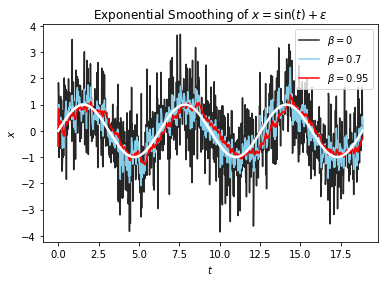

In [23]:
x = np.linspace(0, 6 * np.pi, 1000)
y = np.sin(x) + np.random.randn(len(x))

df = pd.Series(data=y, index=x)
ewm = lambda df, beta: df.ewm(alpha=1-beta).mean().values

plt.plot(x, ewm(df, beta=0.), color='black', alpha=0.85, label=r'$\beta=0$')
plt.plot(x, ewm(df, beta=0.7), color='skyblue', label=r'$\beta=0.7$')
plt.plot(x, ewm(df, beta=0.95), color='red', label=r'$\beta=0.95$')
plt.plot(x, np.sin(x), color='white', linewidth=2.5)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(loc='upper right')
plt.title(r'Exponential Smoothing of $x=\sin(t) + \varepsilon$')
plt.show()

### Adam

There were many other optimizers that came after SGD, e.g. RProp, RMSProp, and Adagrad. These SGD variants were popular for a few years, but they now all seem to be largely supplanted in deep learning. What ended up replacing them all was Adaptive Moment Estimation, or **Adam** for short. Adam was published in 2014, and even in 2022 it's not too out there to say that SGD and Adam are by far the most common optimizers used for deep learning, though newer improvements to Adam like RAdam and AdamW have gained some ground in the past few years.

Adam works by not just using momentum to smooth the gradients, but to smooth their variances as well. The combination of smoothing both gradients and their variances has been shown to substantially speed up training even for the smallest batch sizes. The way Adam does the smoothing and updating is somewhat unusual though compared to what we've seen. I'll outline the steps, but don't worry if you don't understand what they're doing very well. 

Below is a more mathy explanation of how Adam works. If you're not inclined, you can feel free to skim and then skip to the pytorch implementation. Do at least pay attention to what the hyperparameters $\beta_1, \beta_2, \varepsilon$ conceptually do, should you ever care to tweak them during training (usually you won't though).

Instead of just keeping track of the smoothed gradients $m_t$, Adam also keeps track of the smoothed gradient variances $v_t$ (technically the gradient second moments). Annoyingly though, Adam calculates these smoothing terms in a slightly different way than SGD with momentum does,
$$\boldsymbol{m}_t = \beta_1 \boldsymbol{m}_{t-1} + (1-
\beta_1) \frac{dL(\boldsymbol{\theta}_t)}{d\boldsymbol{\theta}},$$
$$\boldsymbol{v}_t = \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2)\bigg(\frac{dL(\boldsymbol{\theta}_t)}{d\boldsymbol{\theta}}\bigg)^2.$$

Note the square of the gradient in the $\boldsymbol{v}_t$ term is calculated *elementwise*. The values $\beta_1, \beta_2$ are the momentum hyperparameters, but in this formulation they only take values between 0 and 1. Values of $\beta=0$ mean no smoothing, while values of $\beta=1$ mean infinite smoothing. The original Adam paper recommends (and these are the pytorch defaults) beta values of $\beta_1=0.9$ and $\beta_2=0.999$. 

Notice that this is *a lot* of smoothing, especially on the variances. To get an idea how much smoothing it's doing, a good rule of thumb is that the number of previous iterations $n$ it's averaging over at any time $t$ is the last
$$n \approx \frac{1}{1 - \beta}$$
iterations. So for $\beta_1=0.9$, $m_t$ is averaging over about $n\approx 10$ iterations. For $\beta_2=0.999$, $v_t$ is averaging over about $n\approx 1000$ iterations. Note these are iterations (the number of batches the model sees), not epochs. Each epoch can have thousands or millions of iterations. Another effect of this is that the biases die off pretty quickly, since $m_0=0$ will be forgotten in just 10 iterations, and $v_0=0$ in just 1000 iterations.

Despite the fact that the biases die off quickly, Adam implements **bias correction** on these smoothed gradients to ensure that the $t=0$ terms have no impact early on. Bias correction is done by dividing each smoothed estimate by a factor $1/(1-\beta)$, like so:
$$
\begin{aligned}
    \boldsymbol{\hat m}_t & = \frac{\boldsymbol{m}_t}{1 - \beta_1^t}, \\
    \boldsymbol{\hat v}_t & = \frac{\boldsymbol{v}_t}{1 - \beta_2^t}.
\end{aligned}
$$

Since we showed the bias terms $m_0,v_0$ die off pretty quickly in training, these corrections really don't do that much, as $\beta^t \approx 0$ when $t$ gets large, hence $\boldsymbol{\hat m}_t \approx \boldsymbol{m}_t$ and $\boldsymbol{\hat v}_t \approx \boldsymbol{v}_t$. Nevertheless, these terms are still included in the algorithm.

The final step of Adam is to update the parameters. This will be done as follows.
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac{\boldsymbol{\hat m}_t}{\sqrt{\boldsymbol{\hat v}_t}+\varepsilon}.$$
We use the $\boldsymbol{\hat m}_t$ term here just like we did $\boldsymbol{m}_t$ in SGD with momentum. The main difference is we're now (elementwise) dividing by the gradient "standard deviations" $\sqrt{\boldsymbol{\hat v}_t}$. Since these values can become zero (why not) and make the denominator zero, we'll add a very small numerical value $\varepsilon$ to keep that from happening. This ensures that even if $\boldsymbol{\hat v}_t \approx 0$ that the denominator will never be zero, which is better for the optimizer's numerical stability. The default value for epsilon is $\varepsilon=10^{-8}$, a really small number indeed.

Let's try to visualize what Adam is doing to the gradients during training on a simple example, just a linear model with no bias, so there's only one parameter, a scalar $\theta$. We'll just try to learn a line to fit $y=x+\varepsilon$ with a line $\hat y = \theta x$. Obviously, it should learn that $\theta=1$, which it quickly does. We'll generated 1000 points, but only use a batch size of 10. Even though we don't have to uses batches here, it's important so that we introduce randomness into the gradient estimates.

The goal here isn't to see how well we can train the model. That's easy. What we want to see is how the *gradient* of $\theta$ (i.e. the slope), is changing over time as the model trains. Call the gradient $g\equiv \frac{dL}{d\theta}$. We'll keep track of each $g_t$ as well as its smoothed variants $\hat m_t$ and $\hat m_t \big/(\sqrt{\hat v_t}+\varepsilon)$. How we'll access the optimizer and model internals to get $g_t, \hat m_t, \hat v_t$ during training isn't really important. Just that we're going to cache them in a dictionary `grad_dict` and then plot them after training is done.

In [24]:
X = torch.linspace(0, 10, 1000).reshape(-1, 1)
Y = X + torch.randn(len(X)).reshape(-1, 1)
dataloader = DataLoader([(X[i],Y[i]) for i in range(len(X))], batch_size=10)

model = nn.Linear(1, 1, bias=False)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.9))

grad_dict = {'grad': [], 'grad_avg': [], 'grad_sq_avg': []}
for epoch in range(10):
    for x, y in dataloader:
        # model training
        opt.zero_grad()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        opt.step()
        # recording gradients
        theta = tuple(model.parameters())[0]
        grad_dict['grad'].append(theta.grad.detach().numpy().item())
        grad_dict['grad_avg'].append(opt.state[theta]['exp_avg'].detach().numpy().item())
        grad_dict['grad_sq_avg'].append(opt.state[theta]['exp_avg_sq'].detach().numpy().item())      
grad_dict = {k: np.array(v) for k, v in grad_dict.items()}

Let's first visualize the fit of the curve to make sure everything is looking good. The line appears to be a pretty good fit. Now let's look at the gradients.

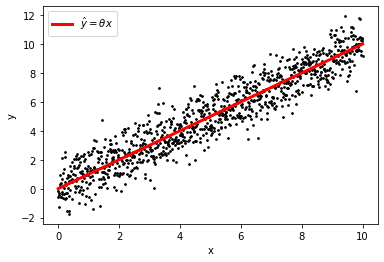

In [25]:
yhat = model(X).detach()

plt.scatter(X.numpy(), Y.numpy(), color='black', s=3)
plt.plot(X.numpy(), yhat.numpy(), color='red', linewidth=3, label=r'$\hat y=\theta x$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Let's plot the gradients $g_t$ and the smoothed gradients $m_t$ over time. Notice how much noisier the batch estimated gradients are. The smaller the batch size, the noiser these will tend to be. The smoothed gradients $m_t$ seems to be smoothing them out pretty well, as desired.

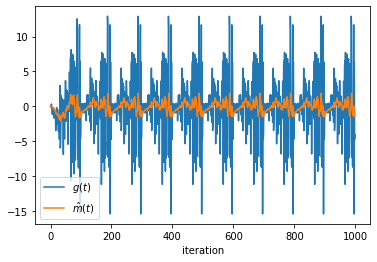

In [26]:
plt.plot(grad_dict['grad'], label=r'$g(t)$')
plt.plot(grad_dict['grad_avg'], label=r'$\hat m(t)$')
plt.legend()
plt.xlabel('iteration')
plt.show()

Let's now look at the square of the gradients $g_t^2$ and compare those to the smoothed gradient squares $v_t$. Recall these are proxies for the variance of the gradients (the square root $\sqrt{v_t}$ being a proxy of the smoothed standard deviation of the gradients). Again, smoothing seems to be doing its job here.

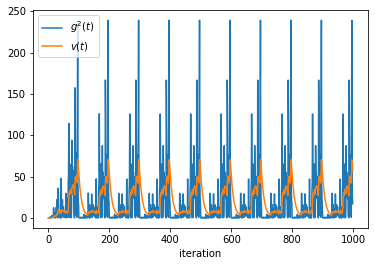

In [27]:
plt.plot(grad_dict['grad']**2, label=r'$g^2(t)$')
plt.plot(grad_dict['grad_sq_avg'], label=r'$v(t)$')
plt.legend()
plt.xlabel('iteration')
plt.show()

Last, let's plot the gradient $g_t$, the smoothed gradient $m_t$, and the "normalized" gradient $\hat m_t \big/(\sqrt{\hat v_t}+\varepsilon)$. We can see that the normalized gradients (in red) are smoother than the smoothed gradients (in green), which are themselves smoother than the estimated gradients (in blue). 

Note that these values control the step sizes that the optimizer takes! In SGD without momentum, no smoothing is done, so our step sizes are going to go like the blue values $g_t$, which bounce all over the place. In SGD with momentum, we get more smoothing with $m_t$, but still some noisiness. The step sizes still bounce around a little bit. In Adam, we get *even more* smoothing, and you can hardly tell the step sizes are bouncing around at all (at least at the scale of the plot). This will generally be true.

Feel free to alter the hyperparameters above to see how these plots change. Try changing the values of `beta` and the batch size to see how they visually affect how the gradient changes during training. You'll see some interesting behaviors, which will give you some intuition for how these optimizers work.

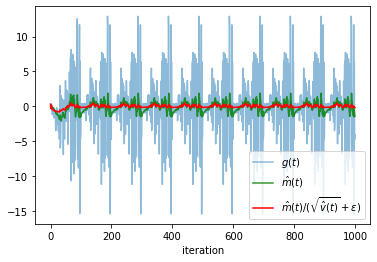

In [28]:
plt.plot(grad_dict['grad'], alpha=0.5, label=r'$g(t)$')
plt.plot(grad_dict['grad_avg'], alpha=0.8, label=r'$\hat m(t)$', color='green')
plt.plot(grad_dict['grad_avg'] / np.sqrt(grad_dict['grad_sq_avg'] + 1e-8), 
         label=r'$\hat m(t)/(\sqrt{\hat v(t)}+\epsilon)$', color='red')
plt.legend(loc='lower right')
plt.xlabel('iteration')
plt.show()

We can optionally add in **weight decay** to Adam just like with SGD. It turns out though that the authors implemented weight decay incorrectly, using the same weight decay factor as used with SGD. It'll still work mostly well in practice if you use it, but it's not *really* weight decaying correctly anymore, since the smoothing terms actually change what the gradients of the loss look like, and hence what the weight decay penalty term looks like. A newer optimizer called AdamW will rectify this little deficiency.

Even still, Adam is still the most popular optimizer used to train deep learning models, and we'll probably end up using it most of the time in these tutorials. Adam is a pretty fast optimizer, allowing you to use learning rates much higher than SGD would typically let you get away with.

**Moral:** Adam has been by far the most successful deep learning optimizer over the past decade. It's still the most widely used in practice, and will work fine most of the time. As a default, I'd consider Adam for your deep learning task unless you have a good reason not to (see the optimizers below for examples). It's also still true that in *some* applications (e.g. object detection) SGD actually tends performs better than Adam much of the time. If you're doing one of those applications, perhaps just consider using SGD.

In pytorch, we can implement Adam using `torch.optim.Adam`. Here's an example, where we're using the default values for the betas and epsilon. (You don't actually have to pass them in if they're default values. I just do it so you can see them if you ever want to tweak them.)

In [29]:
opt = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

The next two optimizers we'll mention are newer. They're just minor tweaks to Adam designed to correct some of its deficiencies. They mostly still work exactly the same as Adam does. Nevertheless, they are becoming more widely used.

### AdamW

AdamW works exactly the same way Adam does, except it does one tweak at the beginning of each step to make weight decay come out correctly (recall that it doesn't come out quite correctly for Adam). 

The calculations for $\boldsymbol{\hat m}_t, \boldsymbol{\hat v}_t$ are exactly the same. The only difference is that we tweak the gradient update step at the end by subtracting the correction term shown in red below,
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac{\boldsymbol{\hat m}_t}{\sqrt{\boldsymbol{\hat v}_t}+\varepsilon} \color{red}{- \alpha \lambda \boldsymbol{\theta}_{t-1}}.$$

This small correction ensures that weight decay for Adam works exactly like it's supposed to, i.e. that the L2 penalty term from the regularized loss function gives the correct weight decay penalty term in the gradient update.

Notice if $\lambda=0$, we just get the regular Adam update. That is, AdamW reverts to just plain Adam if no weight decay is used.

**Moral:** Everything new that happens with AdamW involves weight decay. If you're not going to use much if any weight decay, it doesn't matter whether you use Adam or AdamW. If you *do* need to use a lot of weight decay (perhaps you have a small dataset you're training on), then perhaps consider using AdamW.

Implementing AdamW in pytorch works exactly the way Adam does, even taking in the same parameters. Here's an example using the defaults, with a light weight decay added.

In [30]:
opt = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

### RAdam

One strange feature of using Adam with some of the modern architectures we haven't covered yet, like transformers, is the need for *warmups* early in training. Essentially, with some types of neural network architectures, Adam has a tendency early in training to diverge or converge to poor minima. What seems to be happening is that the variance term $v_t$ is getting too small early in training, causing the *effective learning rate*
$$\alpha_{\text{eff}} \equiv \frac{\alpha}{\sqrt{v_t} + \varepsilon}$$
to get really large, which as you'll recall means that training will fail to converge since the optimizer just bounces around the loss surface. This problem only seems to happen early in training, with $v_t$ eventually settling down to larger values later on, bringing the $\alpha_{\text{eff}}$ down again. Nevertheless, this tendency to bounce around early in training can mean longer training times or having to tune the hyperparameters more.

One way around this warmups issue is to use a learning rate scheduler that includes a warmup period. That is, instead of starting with the specified learning rate, it starts training with a much lower learning rate, and ramps up to the specified learning rate after so many iterations. One example of a scheduler that does this is one-cycle, which starts low and ramps up the learning rate to the max over a specified number of iterations (usually something like a third of an epoch). If you use Adam with a one-cycle scheduler, you'll probably be fine.

Another way around this is to just go ahead and "fix" Adam to keep this early divergence issue from happening in the first place, essentially baking a warmup period into the optimizer directly. This is what Rectified Adam, or **RAdam**, does. It again essentially reproduces Adam except for some tweaking, the introduction of a *rectifier* term $\rho_t$ that's designed to keep the effective learning rate from blowing up early in training. If $\rho_t$ is smaller than some threshold value (in pytorch it's 5), then RAdam ignores $v_t$ and just uses $m_t$ to update the gradients:
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \boldsymbol{\hat m}_t.$$
This tends to happen earlier in training, say the first 5 or so iterations.

When $\rho_t$ is greater than that threshold value (all but the first few iterations), RAdam will use the Adam update rule, but with a correction factor $r_t$. This $r_t$ factor goes to 1 after a few thousand iterations, effectively restoring the original version of Adam,
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac{\boldsymbol{\hat m}_t}{\sqrt{\boldsymbol{\hat v}_t}+\varepsilon} \color{red}{r_t}.$$

Unfortunately, this $r_t$ value is calculated in a rather exotic way. I won't delve into why it's done this way, but feel free to check out the [paper](https://arxiv.org/abs/1908.03265) if you're curious. Anyway, the update equations for $\rho_t$ and $r_t$ are,
$$
\begin{aligned}
    \rho_{\infty} & = \frac{2}{1-\beta_2}-1, \\
    \rho_t & = \rho_{\infty} - 2t\frac{\beta_2^t}{1-\beta_2^t}, \\
    r_t & = \sqrt{\frac{(\rho_t-4)(\rho_t-2)\rho_{\infty}}{(\rho_{\infty}-4)(\rho_{\infty}-2)\rho_t}}.
\end{aligned}
$$

Here's a quick calculation to show that for the default value of $\beta_2=0.999$,
- $\rho_t$ is less than the threshold 5 only in the earliest iterations of training, and
- $r_t$ goes to 1 after a few thousand iterations.

In [31]:
beta_2 = 0.999
rho_inf = 2 / (1-beta_2) - 1
print(f'beta_2 = {beta_2} (default)')
print(f'rho_inf = {round(rho_inf)}')
print(f'{"t":<15} {"rho_t":<25} {"r_t":<25} {"rho_t > 5":<15}')
print('-'*77)
for t in [1, 2, 5, 10, 100, 1000, 10_000, 100_000]:
    rho_t = rho_inf - 2 * t * beta_2**t / (1 - beta_2**t)
    r_t = np.sqrt(((rho_t - 4) * (rho_t - 2) * rho_inf) / ((rho_inf - 4) * (rho_inf - 2) * rho_t))
    print(f'{t:<15} {rho_t:<25} {r_t:<25} {bool(rho_t > 5)}')

beta_2 = 0.999 (default)
rho_inf = 1999
t               rho_t                     r_t                       rho_t > 5      
-----------------------------------------------------------------------------
1               1.0                       0.038797750152842335      False
2               1.999499749846109         0.0005011274101805306     False
5               4.995998000395048         0.017311503166315034      False
10              9.98349177230557          0.04899801344710748       True
100             98.33294432272578         0.21533543653820142       True
1000            835.9673756107934         0.6453256523380656        True
10000           1998.0964922659898        0.9997733049343513        True
100000          1998.9999999999982        1.0                       True


**Moral:** Everything RAdam is trying to do involves the early iterations of training, where for some types of neural architectures the loss might blow up (or just not converge) early on if using Adam. If you're using a more modern neural network (e.g. a deeper CNN or transformer), consider using *either* Adam with a warmup scheduler like one-cycle, *or* using RAdam.

Using RAdam in pytorch is exactly the same as using Adam and AdamW. Here's the same example again.

In [32]:
opt = torch.optim.RAdam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

## Example: MNIST Model

Let's finish off by training a deeper MLP model and see if we can try to beat our random forest result of 96.8% test set accuracy. The neural architecture we'll use was taken from Yann LeCun's MNIST [website](http://yann.lecun.com/exdb/mnist/), and appeared to be the state of the art for this dataset in 2010 with 99.65% test accuracy. That paper used some techniques we haven't discussed yet, so we won't be able to get that high, but we should be able to do pretty well in just a few epochs using Adam with an appropriate learning rate and batch size. The network consists of 6 layers. We'll go ahead and add in a little bit of dropout and use batch norm, neither of which existed in 2010, but should help speed up training and reduce overfitting.

As mentioned, we'll use Adam as the optimizer (as we usually will from now on) with the same batch size from before of 128 and a learning rate of 0.001 (found using the LR finder). We'll also go ahead and use the one-cycle scheduler on the learning rate to hopefully speed up training even more. Only a *very tiny* amount of regularization is used, with a dropout of `p=0.05` and no weight decay. We'll train for 20 epochs and then print the accuracies and plot the training loss.

In [33]:
num_features = 28 * 28
num_targets = 10

model = multilayer_mlp(num_features, num_targets, [2500, 2000, 1500, 1000, 500], p=0.05, normalization=nn.BatchNorm1d)
model

Sequential(
  (0): Sequential()
  (1): Linear(in_features=784, out_features=2500, bias=True)
  (2): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.05, inplace=False)
  (5): Linear(in_features=2500, out_features=2000, bias=True)
  (6): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.05, inplace=False)
  (9): Linear(in_features=2000, out_features=1500, bias=True)
  (10): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.05, inplace=False)
  (13): Linear(in_features=1500, out_features=1000, bias=True)
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.05, inplace=False)
  (17): Linear(in_features=1000, out_features=500, bias=True)
  (18): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-04


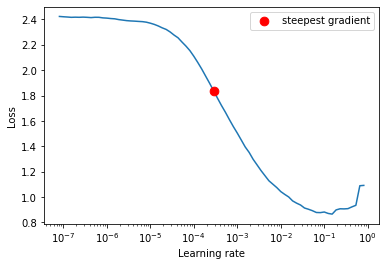

In [34]:
opt = torch.optim.Adam(model.parameters(), lr=1, weight_decay=0.)
loss_fn = nn.CrossEntropyLoss()
lr_find(train_set, model, opt, loss_fn, batch_size=batch_size, start_lr=1e-8, end_lr=10)

In [35]:
num_epochs = 20
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
loss_fn = nn.CrossEntropyLoss()
model, losses = train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=test_loader,
                            scheduler=scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 0 		 train loss: 0.2779805660247803 		 test loss: 0.10356898605823517


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 2 		 train loss: 0.09546453505754471 		 test loss: 0.10148369520902634


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 4 		 train loss: 0.0727962777018547 		 test loss: 0.09059964865446091


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 6 		 train loss: 0.04629196971654892 		 test loss: 0.07621528208255768


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 8 		 train loss: 0.034378938376903534 		 test loss: 0.08281711488962173


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 10 		 train loss: 0.02259618043899536 		 test loss: 0.08349832147359848


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 12 		 train loss: 0.013971102423965931 		 test loss: 0.06901877373456955


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 14 		 train loss: 0.00562494108453393 		 test loss: 0.06360743939876556


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 16 		 train loss: 0.001588535262271762 		 test loss: 0.06610836088657379


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 18 		 train loss: 0.0005473836790770292 		 test loss: 0.059599652886390686


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 19 		 train loss: 0.0003887678903993219 		 test loss: 0.0568363331258297


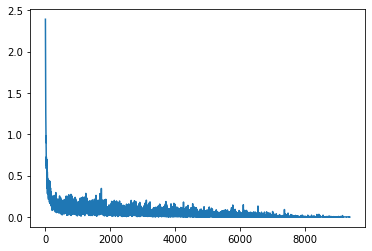

In [36]:
plt.plot(losses)

In [37]:
get_scores(train_loader, model, accuracy_score, test_loader=test_loader)

avg train accuracy_score: 1.0
avg test accuracy_score: 0.9872428797468354


It looks like we were able to hit 98.7% accuracy on the test set, almost 2% higher than the random forest was able to do. Notice also that we're hitting 100% accuracy on the training set. You may think that means we're overfitting, but not really. Remember, in deep learning, overfitting happens when the test loss starts consistently increasing. It's not at all uncommon to hit 100% training accuracy, yet still be able to keep training and improve test accuracy. It's still somewhat a curiosity why deep neural networks are able to do this. If you're curious, check out this [blog post](https://mlu-explain.github.io/double-descent/) series on the phenomenon of **double descent**.